# Multi-Symbol Micro Model Backtest 
This notebook verifies the model's accuracy across multiple symbols (`AAPL`, `NVDA`, `INTC`).
It visualizes:
1. **Price Comparison**: Actual vs Predicted Close Price.
2. **Returns Comparison**: Actual vs Predicted Daily Returns (Line Graph).

In [45]:
import sys
import os
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Add project root to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.config.settings import settings
from src.tools.model.neural import HybridStockNet
from src.tools.model.data import TvDataFetcher
from src.tools.model.feature import FeatureCalculator
from src.utils.device import get_device

device = get_device()
print(f"Device: {device}")

# Initialize Components
tv_data_fetcher = TvDataFetcher()
features = FeatureCalculator()

2025-12-26 17:04:02,518 - src.utils.device - INFO - Device detected: CPU


Device: cpu


In [46]:
# Retrain Model
from src.tools.model.train import StockModelTrainer

print("Starting training session...")
trainer = StockModelTrainer()
# Using symbols relevant to our analysis + others for generalization
train_result = trainer.train(
    symbols=["AAPL", "MSFT", "NVDA", "GOOGL", "AMZN"], 
    num_epochs=30, 
    batch_size=32
)

print("Training Result:", train_result)

Starting training session...
2025-12-26 17:04:02,527 - src.tools.model.train - INFO - Trainer initialized. Target device: cpu.
2025-12-26 17:04:02,527 - src.tools.model.train - INFO - Trainer.train started. Device: cpu
2025-12-26 17:04:02,527 - src.tools.model.train - INFO - Starting data fetch and feature engineering for 5 symbols...
2025-12-26 17:04:02,528 - src.tools.model.train - INFO - Fetching data for AAPL...
2025-12-26 17:04:03,155 - src.tools.model.train - INFO - Success for AAPL: Created 497 sequences.
2025-12-26 17:04:03,156 - src.tools.model.train - INFO - Fetching data for MSFT...
2025-12-26 17:04:04,150 - src.tools.model.train - INFO - Success for MSFT: Created 497 sequences.
2025-12-26 17:04:04,151 - src.tools.model.train - INFO - Fetching data for NVDA...
2025-12-26 17:04:04,961 - src.tools.model.train - INFO - Success for NVDA: Created 497 sequences.
2025-12-26 17:04:04,962 - src.tools.model.train - INFO - Fetching data for GOOGL...
2025-12-26 17:04:06,072 - src.tools.

In [47]:
# Load Model
model = HybridStockNet(
    input_size=settings.INPUT_SIZE,
    hidden_dim=settings.HIDDEN_DIM,
    num_layers=settings.NUM_LAYERS,
    dropout=settings.DROPOUT
).to(device)

if settings.MODEL_PATH.exists():
    model.load_state_dict(torch.load(settings.MODEL_PATH, map_location=device))
    model.eval()
    print("Model loaded from:", settings.MODEL_PATH)
else:
    print("Model not found. Please train first.")

Model loaded from: /home/mango/Documents/Work/Code Projects/StockAgent/data/datasets/models/micro.pth


In [48]:
def collect_data(symbol, days=365):
    print(f"[{symbol}] Fetching data...")
    df = tv_data_fetcher.fetch_historical_data(symbol, timeframe_days=days, exchange="NASDAQ")
    if isinstance(df, dict) and "error" in df:
         df = tv_data_fetcher.fetch_historical_data(symbol, timeframe_days=days, exchange="NYSE")
    if isinstance(df, dict) and "error" in df:
        return None

    try:
        feature_df = features.calculate_features(df.copy())
    except Exception:
        return None
        
    input_data = feature_df[settings.FEATURE_COLUMNS].values
    SEQ_LEN = settings.SEQ_LEN
    if len(input_data) < SEQ_LEN: return None

    sequences = []
    valid_dates = []
    valid_prices = []
    seq_prev_prices = []
    
    # Note: feature_df indices align with df['close'], but feature_df has dropped rows
    for i in range(SEQ_LEN, len(feature_df)):
        sequences.append(input_data[i-SEQ_LEN : i])
        
        # Use INDEX matching to align with original df
        target_idx = feature_df.index[i]
        valid_dates.append(target_idx)
        valid_prices.append(df['close'].loc[target_idx])
        
        # Previous price is the last step of the input sequence
        prev_idx = feature_df.index[i-1]
        seq_prev_prices.append(df['close'].loc[prev_idx])
    
    predicted_prices = []
    actual_returns = []
    predicted_returns = []

    with torch.no_grad():
        for i in range(len(sequences)):
            seq = sequences[i]
            prev_price = seq_prev_prices[i]
            
            tensor_seq = torch.tensor(seq, dtype=torch.float32).unsqueeze(0).to(device)
            pred_log_ret = model(tensor_seq).item()
            
            # Descale by 100.0
            pred_price = prev_price * np.exp(pred_log_ret / 100.0)
            predicted_prices.append(pred_price)
            
            # Returns
            act_ret = (valid_prices[i] - prev_price) / prev_price
            pred_ret = (pred_price - prev_price) / prev_price
            actual_returns.append(act_ret)
            predicted_returns.append(pred_ret)
            
    # Directional Accuracy
    correct = 0
    for i in range(len(actual_returns)):
        if (actual_returns[i] * predicted_returns[i]) > 0:
            correct += 1
    if len(actual_returns) > 0:
        acc = (correct / len(actual_returns)) * 100
    else:
        acc = 0.0

    # Diagnostic Statistics
    pred_log_rets = np.array([np.log(p/prev) for p, prev in zip(predicted_prices, seq_prev_prices)])
    print(f"[{symbol}] Pred Return Stats: Mean={pred_log_rets.mean():.5f}, Std={pred_log_rets.std():.5f}, Min={pred_log_rets.min():.5f}, Max={pred_log_rets.max():.5f}")

    return {
        "dates": valid_dates,
        "actual": valid_prices,
        "predicted": predicted_prices,
        "act_ret": actual_returns,
        "pred_ret": predicted_returns,
        "acc": acc
    }

In [49]:
# Run Analysis
symbols = ["AAPL", "NVDA", "MSFT"]
results = {}

for sym in symbols:
    data = collect_data(sym)
    if data:
        results[sym] = data
        print(f"{sym}: {data['acc']:.1f}% Directional Accuracy")

[AAPL] Fetching data...
[AAPL] Pred Return Stats: Mean=0.01049, Std=0.00995, Min=-0.01461, Max=0.02981
AAPL: 52.6% Directional Accuracy
[NVDA] Fetching data...
[NVDA] Pred Return Stats: Mean=0.01111, Std=0.00904, Min=-0.01316, Max=0.02832
NVDA: 56.8% Directional Accuracy
[MSFT] Fetching data...
[MSFT] Pred Return Stats: Mean=0.01065, Std=0.00972, Min=-0.01547, Max=0.02963
MSFT: 50.4% Directional Accuracy


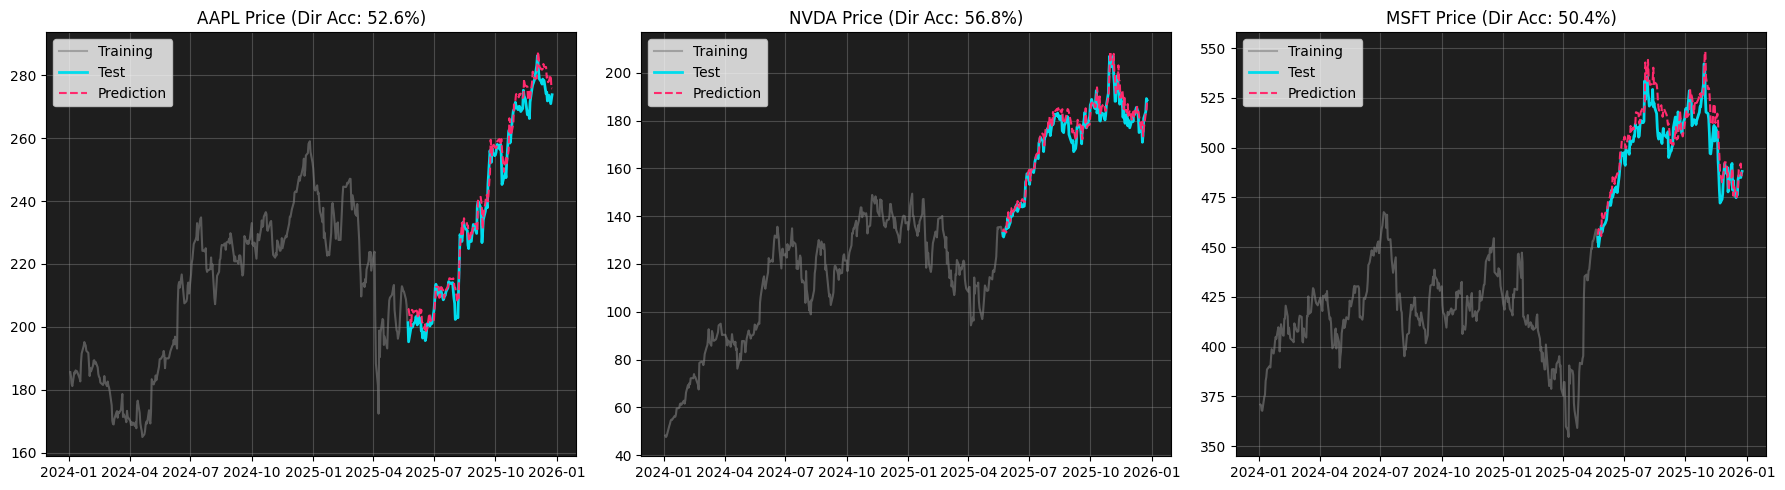

In [50]:
# Plot 1: Prices (3 Subplots) - TRAINING (65%) vs TEST (35%)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, sym in enumerate(symbols):
    ax = axes[i]
    if sym in results:
        res = results[sym]
        dates = res['dates']
        # Ensure arrays for easy indexing
        actual = np.array(res['actual'])
        predicted = np.array(res['predicted'])
        
        # Calculate split index (65% Train, 35% Test)
        split_idx = int(len(dates) * 0.7)
        
        # 1. Training Graph (First 65% Actual)
        ax.plot(dates[:split_idx], actual[:split_idx], label='Training', color='gray', alpha=0.6, linewidth=1.5)
        
        # 2. Test Graph (Last 35% Actual)
        ax.plot(dates[split_idx:], actual[split_idx:], label='Test', color='#00dcec', linewidth=2)
        
        # 3. Prediction Graph (Last 35% Predicted)
        ax.plot(dates[split_idx:], predicted[split_idx:], label='Prediction', color='#ff2a6d', linestyle='--', linewidth=1.5)
        
        ax.set_title(f"{sym} Price (Dir Acc: {res['acc']:.1f}%)")
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_facecolor('#1e1e1e')

plt.tight_layout()
plt.show()

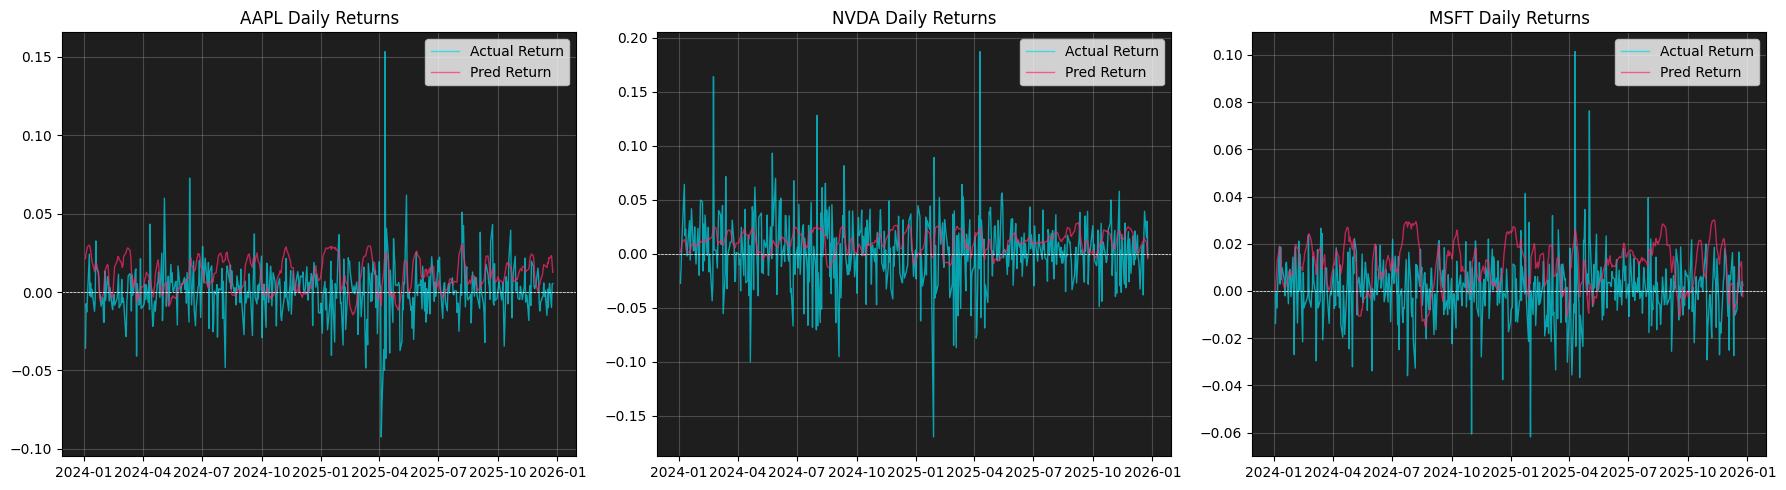

In [51]:
# Plot 2: Returns (Linear Line Graph)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, sym in enumerate(symbols):
    ax = axes[i]
    if sym in results:
        res = results[sym]
        # Plotting Returns over Time
        ax.plot(res['dates'], res['act_ret'], label='Actual Return', color='#00dcec', linewidth=1, alpha=0.7)
        ax.plot(res['dates'], res['pred_ret'], label='Pred Return', color='#ff2a6d', linewidth=1, alpha=0.7)
        
        ax.axhline(0, color='white', linestyle='--', linewidth=0.5)
        ax.set_title(f"{sym} Daily Returns")
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_facecolor('#1e1e1e')

plt.tight_layout()
plt.show()